In [1]:
# matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
# pandas
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)
# numpy
import numpy as np
# keras; not sure which version
# API changes frequently, so...
import keras
from keras.models import Sequential                                     
from keras.layers.core import Dense
from keras.wrappers.scikit_learn import KerasRegressor
# from keras.layers.normalization import BatchNormalization
# from keras.optimizers import SGD        
# from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# normal
import time
import os

Using TensorFlow backend.


# Load dataset

In [2]:
# load dataset
dataframe = pd.read_csv("housing.csv", delim_whitespace=True, header=None,
                        names=['crim', 'zn', 'indus', 'chas', 'nox',
                               'rm', 'age', 'dis', 'rad', 'tax',
                               'ptratio', 'black', 'lstat', 'medv'])
dataset = dataframe.values
dataframe.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.006,18.000,2.310,0,0.538,6.575,65.200,4.090,1,296.000,15.300,396.900,4.980,24.000
1,0.027,0.000,7.070,0,0.469,6.421,78.900,4.967,2,242.000,17.800,396.900,9.140,21.600
2,0.027,0.000,7.070,0,0.469,7.185,61.100,4.967,2,242.000,17.800,392.830,4.030,34.700
3,0.032,0.000,2.180,0,0.458,6.998,45.800,6.062,3,222.000,18.700,394.630,2.940,33.400
4,0.069,0.000,2.180,0,0.458,7.147,54.200,6.062,3,222.000,18.700,396.900,5.330,36.200


In [3]:
dataframe.describe()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
count,506.000,506.000,506.000,506.000,506.000,506.000,506.000,506.000,506.000,506.000,506.000,506.000,506.000,506.000
mean,3.614,11.364,11.137,0.069,0.555,6.285,68.575,3.795,9.549,408.237,18.456,356.674,12.653,22.533
std,8.602,23.322,6.860,0.254,0.116,0.703,28.149,2.106,8.707,168.537,2.165,91.295,7.141,9.197
min,0.006,0.000,0.460,0.000,0.385,3.561,2.900,1.130,1.000,187.000,12.600,0.320,1.730,5.000
25%,0.082,0.000,5.190,0.000,0.449,5.886,45.025,2.100,4.000,279.000,17.400,375.377,6.950,17.025
50%,0.257,0.000,9.690,0.000,0.538,6.208,77.500,3.207,5.000,330.000,19.050,391.440,11.360,21.200
75%,3.677,12.500,18.100,0.000,0.624,6.623,94.075,5.188,24.000,666.000,20.200,396.225,16.955,25.000
max,88.976,100.000,27.740,1.000,0.871,8.780,100.000,12.127,24.000,711.000,22.000,396.900,37.970,50.000


Let's start getting a feel for the data, starting by evaluating suspicious values

Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'black', 'lstat'],
      dtype='object')


<IPython.core.display.Javascript object>


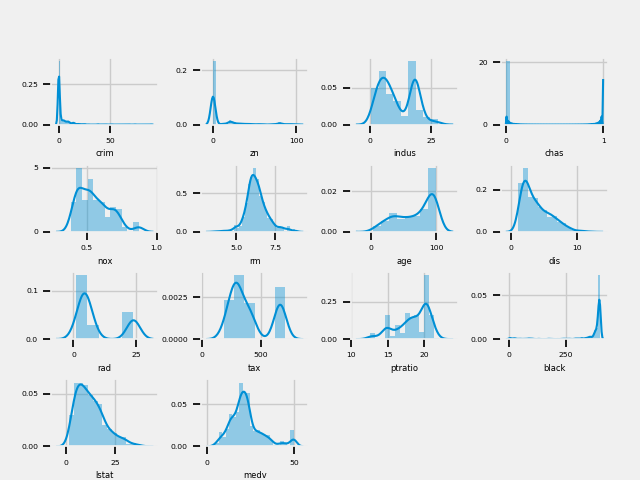

/home/harperes/miniconda3/envs/ml/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [4]:
import seaborn as sns
# we have 14 columns...we'll use an unfilled
# 4x4 array
print(dataframe.columns[:13])
sns.set_context("notebook", font_scale=0.5)
fig = plt.figure()
for i, c in enumerate(dataframe.columns):
    ax = fig.add_subplot(4, 4, i+1)
    sns.distplot(dataframe[c], ax=ax)
#     ax.set_xticks(fontsize=10)
fig.subplots_adjust(wspace=0.4, hspace=0.6)
plt.show()
# sns.distplot()

Focus on:

- `chas`
- `zn`
- `age`
- `medv`

<IPython.core.display.Javascript object>


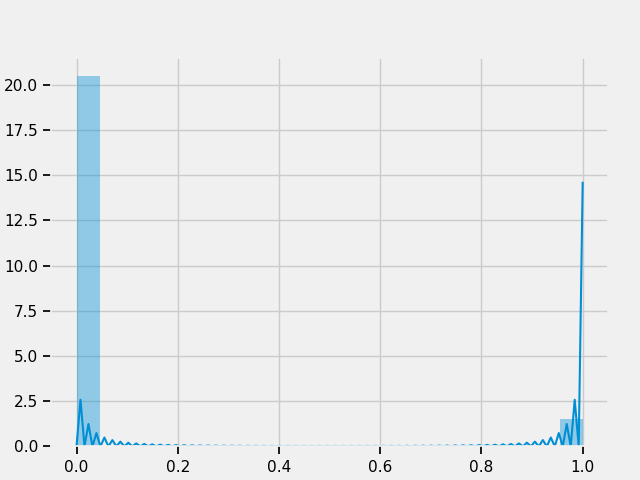

<IPython.core.display.Javascript object>


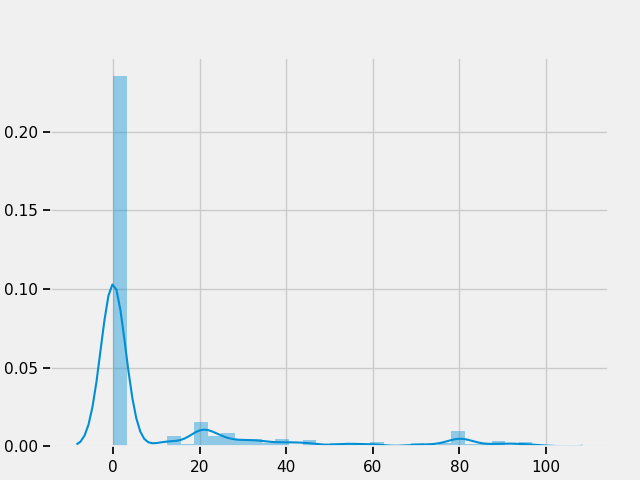

<IPython.core.display.Javascript object>


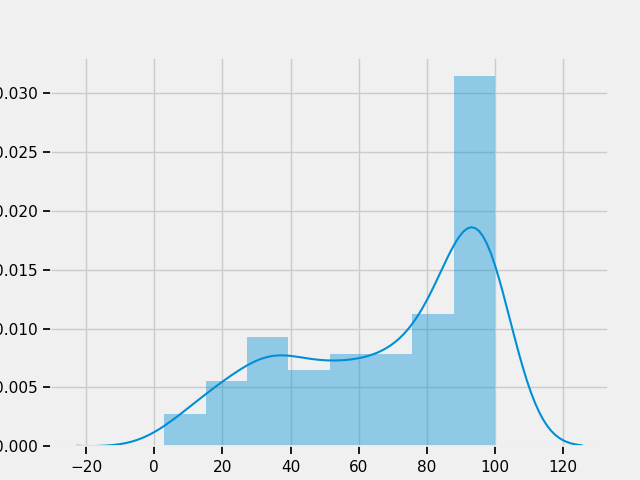

<IPython.core.display.Javascript object>


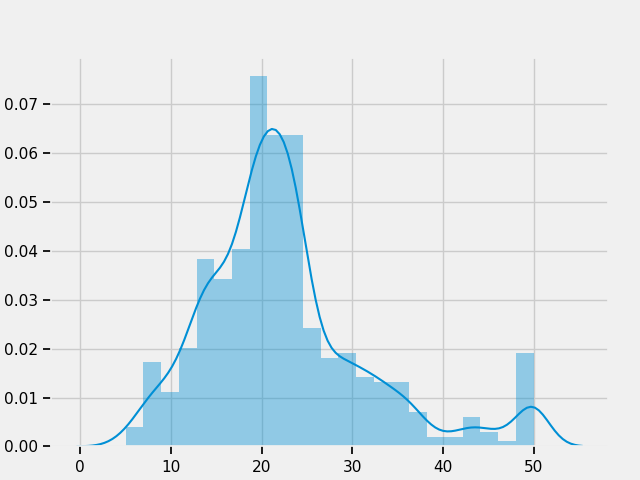

In [5]:
sns.set_context("notebook", font_scale=1.0)
for i, c in enumerate(['chas', 'zn', 'age', 'medv']):
    fig = plt.figure()
    sns.distplot(dataframe[c])
plt.show()
# sns.distplo

There are no obvious outliers or data to clean/ignore.

Let's do a correlation analysis

<IPython.core.display.Javascript object>


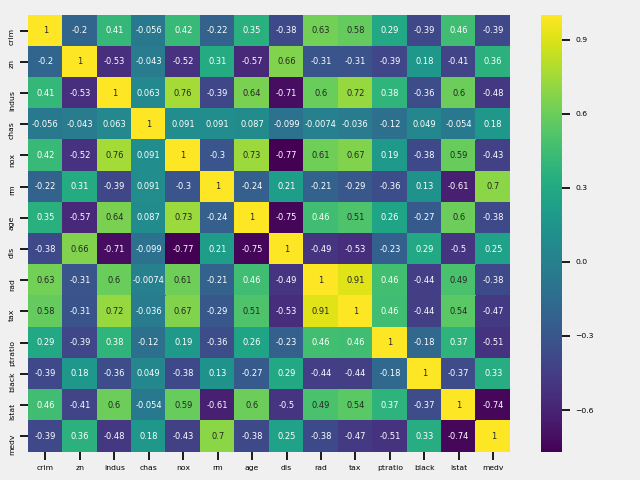

In [6]:
corr = dataframe.corr()
sns.set_context("notebook", font_scale=0.5)
plt.figure()
sns.heatmap(corr, annot=True, cmap='viridis')
plt.tight_layout()
plt.show()

In [19]:
import scipy.special
print(scipy.special.binom(13, 2))

78.0


rather than do our pair plotting, we need to see what, if any, correlation, our independent variables have on our dependent variable

<IPython.core.display.Javascript object>


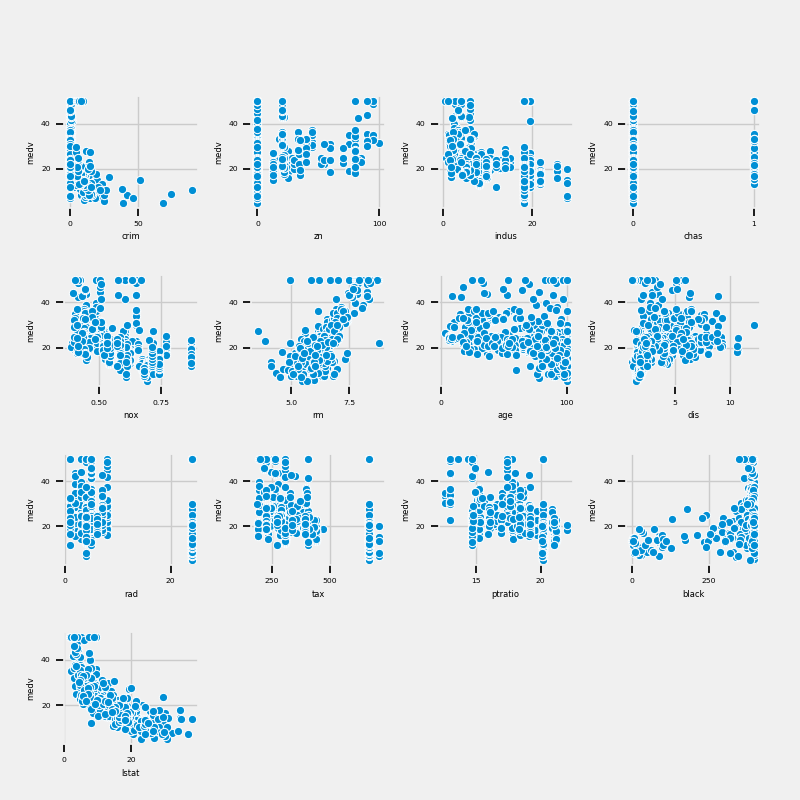

In [7]:
# this is a cool one-liner...but not what we need
# sns.pairplot(dataframe)
sns.set_context("notebook", font_scale=0.5)
fig = plt.figure(figsize=(8,8))
for i, c in enumerate(dataframe.columns[:13]):
    ax = fig.add_subplot(4, 4, i+1)
    sns.scatterplot(dataframe[c], dataframe['medv'], ax=ax)
#     ax.set_xticks(fontsize=10)
fig.subplots_adjust(wspace=0.4, hspace=0.6)
plt.show()

<IPython.core.display.Javascript object>


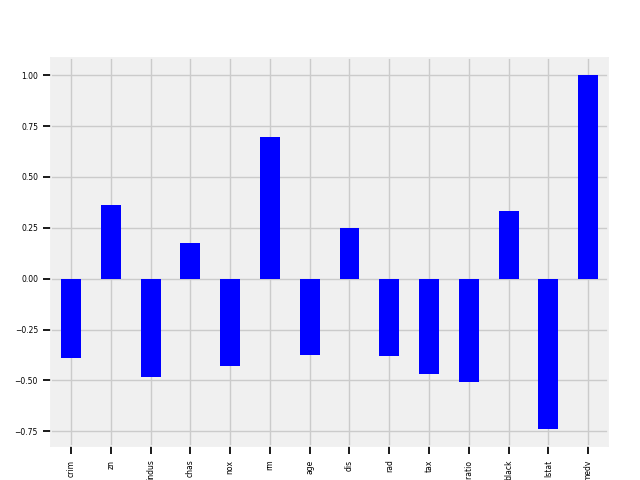

In [10]:
fig = plt.figure()
corr['medv'].plot.bar(color = 'b')
plt.show()

# Start with a linear regression to set a baseline

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

lr = LinearRegression()

X_train, X_valid, y_train, y_valid = train_test_split(dataframe.drop(columns=['medv']), np.array(dataframe['medv']), 
                                                      random_state = 42, test_size = 100)
# use all the data
lr.fit(X_train, y_train)

print('Intercept', round(lr.intercept_, 4))

Intercept 30.1555


In [9]:
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)

def metrics(train_pred, valid_pred, y_train, y_valid):
    """Calculate metrics:
       Root mean squared error and mean absolute percentage error"""
    
    # Root mean squared error
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    valid_rmse = np.sqrt(mean_squared_error(y_valid, valid_pred))
    
    # Calculate absolute percentage error
    train_ape = abs((y_train - train_pred) / y_train)
    valid_ape = abs((y_valid - valid_pred) / y_valid)
    
    # Account for y values of 0
    train_ape[train_ape == np.inf] = 0
    train_ape[train_ape == -np.inf] = 0
    valid_ape[valid_ape == np.inf] = 0
    valid_ape[valid_ape == -np.inf] = 0
    
    train_mape = 100 * np.mean(train_ape)
    valid_mape = 100 * np.mean(valid_ape)
    
    return train_rmse, valid_rmse, train_mape, valid_mape

def evaluate(model, features, X_train, X_valid, y_train, y_valid):
    """Mean absolute percentage error"""
    
    # Make predictions
    train_pred = model.predict(X_train[features])
    valid_pred = model.predict(X_valid[features])
    
    # Get metrics
    train_rmse, valid_rmse, train_mape, valid_mape = metrics(train_pred, valid_pred,
                                                             y_train, y_valid)
    
    print(f'Training:   rmse = {round(train_rmse, 2)} \t mape = {round(train_mape, 2)}')
    print(f'Validation: rmse = {round(valid_rmse, 2)} \t mape = {round(valid_mape, 2)}')

In [10]:
evaluate(lr, dataframe.columns[:13],
         X_train, X_valid, y_train, y_valid)

Training:   rmse = 4.64 	 mape = 16.52
Validation: rmse = 4.96 	 mape = 17.0


In [11]:
train_mean = y_train.mean()

# Create list of the same prediction for every observation
train_preds = [train_mean for _ in range(len(y_train))]
valid_preds = [train_mean for _ in range(len(y_valid))]

tr, vr, tm, vm = metrics(train_preds, valid_preds, y_train, y_valid)

print(f'Baseline Training:   rmse = {round(tr, 2)} \t mape = {round(tm, 2)}')
print(f'Baseline Validation: rmse = {round(vr, 2)} \t mape = {round(vm, 2)}')

Baseline Training:   rmse = 9.3 	 mape = 36.62
Baseline Validation: rmse = 8.75 	 mape = 38.34


We're beating the mean!

<IPython.core.display.Javascript object>


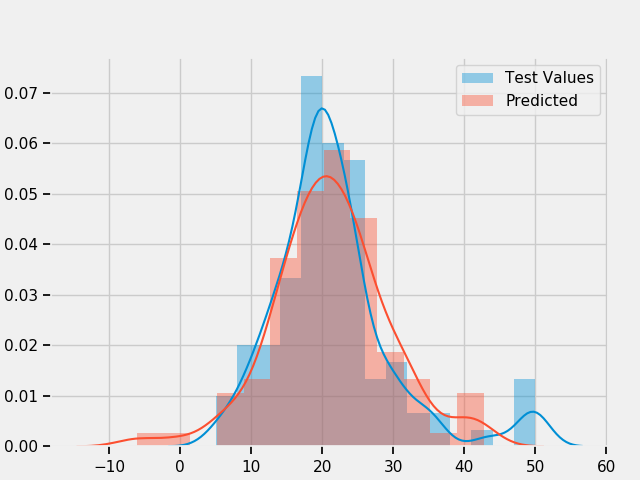

/home/harperes/miniconda3/envs/ml/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [12]:
y_preds = lr.predict(X_valid)
sns.set_context("notebook", font_scale=1)
plt.figure()
sns.distplot(y_valid, label="Test Values")
sns.distplot(y_preds, label="Predicted")
plt.legend()

alternate view of the regression

<IPython.core.display.Javascript object>


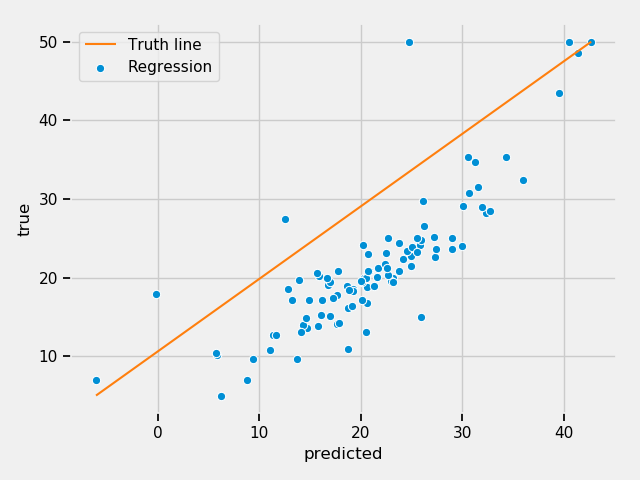

In [13]:
y_pred = lr.predict(X_valid)
fig = plt.figure()
ax = fig.add_subplot(111)
sns.scatterplot(y_pred, y_valid,
                ax=ax, label='Regression')
ax.plot([np.nanmin(y_preds), np.nanmax(y_preds)],
         [np.nanmin(y_valid), np.nanmax(y_valid)],
        label='Truth line', color='tab:orange')
ax.set_xlabel("predicted")
ax.set_ylabel("true")
plt.legend()
plt.tight_layout()
plt.show()

Note that the regression is systematically over-estimating the values...

Let's try to improve (note, we can't use our old standby, the confusion matrix here)

# Support vector regression

In [14]:
from sklearn.svm import SVR

model = SVR()
model.fit(X_train, y_train)
evaluate(model, dataframe.columns[:13],
         X_train, X_valid, y_train, y_valid)

Training:   rmse = 8.6 	 mape = 28.4
Validation: rmse = 8.55 	 mape = 33.61


/home/harperes/miniconda3/envs/ml/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


<IPython.core.display.Javascript object>


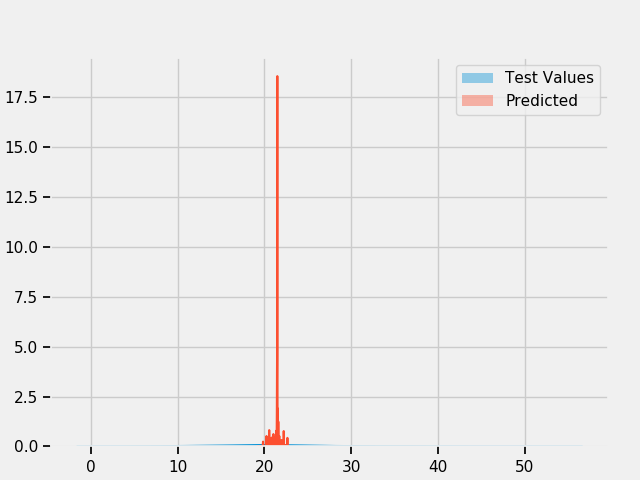

/home/harperes/miniconda3/envs/ml/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [15]:
y_preds = model.predict(X_valid)
sns.set_context("notebook", font_scale=1)
plt.figure()
sns.distplot(y_valid, label="Test Values")
sns.distplot(y_preds, label="Predicted")
plt.legend()

well...that's bad. Probably should scale our data



In [16]:
# model = SVR()
# model = SVR(kernel='rbf', C=1)
model = SVR(kernel='rbf', C=10, gamma=0.1)
scaler = StandardScaler()
scaler.fit(X_train)
model.fit(scaler.transform(X_train), y_train)
X_train_scaled = X_train
X_valid_scaled = X_valid
X_train_scaled[X_train_scaled.columns] = scaler.transform(X_train_scaled[X_train_scaled.columns])
X_valid_scaled[X_train_scaled.columns] = scaler.transform(X_valid[X_train_scaled.columns])
evaluate(model, dataframe.columns[:13],
         X_train_scaled, X_valid_scaled, y_train, y_valid)

Training:   rmse = 2.75 	 mape = 6.71
Validation: rmse = 3.67 	 mape = 11.6


/home/harperes/miniconda3/envs/ml/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/harperes/miniconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  
/home/harperes/miniconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:9: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':
/home/harperes/miniconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:10: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  # Remove the CWD from sys.path while we load stuff.


<IPython.core.display.Javascript object>


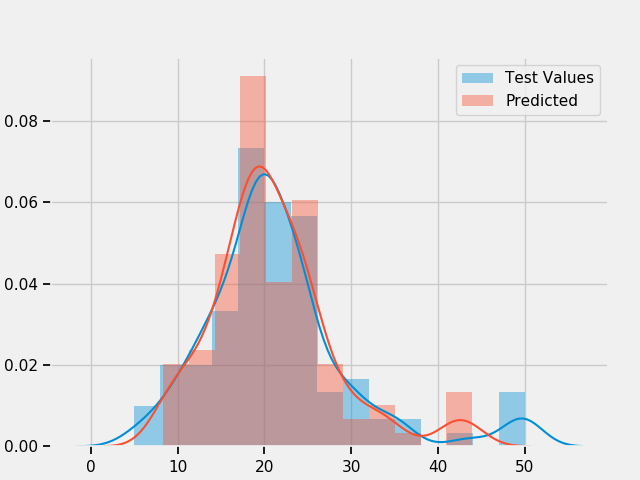

/home/harperes/miniconda3/envs/ml/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [17]:
y_pred = model.predict(X_valid_scaled)
sns.set_context("notebook", font_scale=1)
plt.figure()
sns.distplot(y_valid, label="Test Values")
sns.distplot(y_pred, label="Predicted")
plt.legend()

<IPython.core.display.Javascript object>


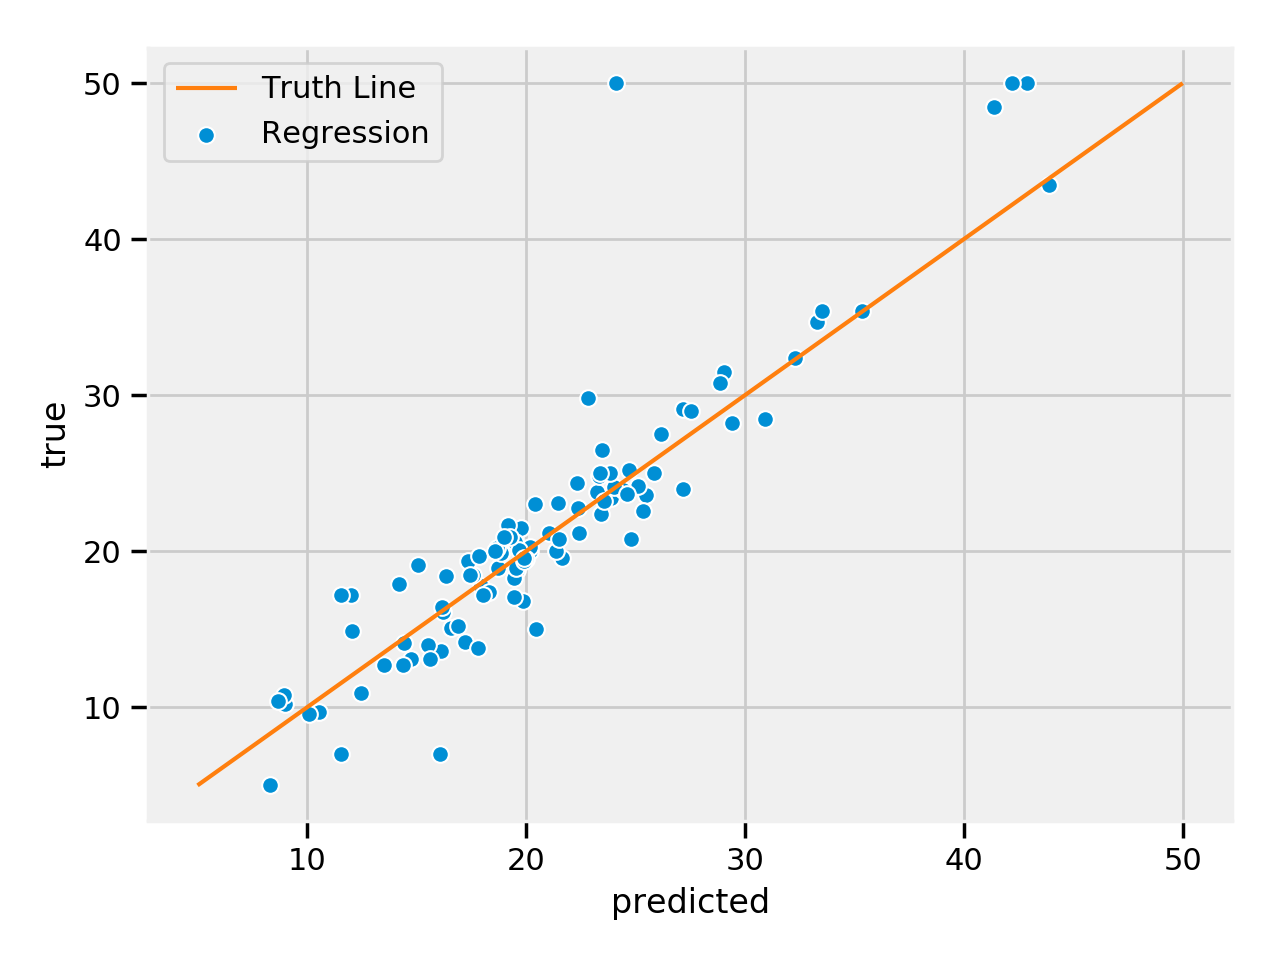

In [261]:
y_pred = model.predict(X_valid_scaled.values)
fig = plt.figure()
ax = fig.add_subplot(111)
sns.scatterplot(y_pred.reshape(-1), y_valid, ax=ax,
                label='Regression')
ax.plot([np.nanmin(y_valid), np.nanmax(y_valid)],
        [np.nanmin(y_valid), np.nanmax(y_valid)],
        color='tab:orange', label="Truth Line")
ax.set_xlabel("predicted")
ax.set_ylabel("true")
plt.legend()
plt.tight_layout()
plt.show()

That was very simple, let's try a hyperparameter sweep

Maybe now we do a hyperparameter sweep?

In [18]:
from sklearn.model_selection import GridSearchCV

model = GridSearchCV(SVR(kernel='rbf', gamma=0.1, epsilon=0.1), cv=5,
                     param_grid=dict(C=[1, 5, 10, 50, 100, 500, 1000],
                                     gamma=np.logspace(-2, 2, 10),
                                     epsilon=np.logspace(-2, 2, 10)))
scaler = StandardScaler()
scaler.fit(X_train)
t0 = time.time()
model.fit(scaler.transform(X_train), y_train)
t1 = time.time()
print(f"time to optimize: {t1-t0}")

time to optimize: 33.087830781936646


/home/harperes/miniconda3/envs/ml/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [19]:
evaluate(model, dataframe.columns[:13],
         X_train_scaled, X_valid_scaled, y_train, y_valid)
print(model.best_estimator_)

Training:   rmse = 1.58 	 mape = 5.19
Validation: rmse = 3.52 	 mape = 11.32
SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.5994842503189409,
  gamma=0.0774263682681127, kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)


<IPython.core.display.Javascript object>


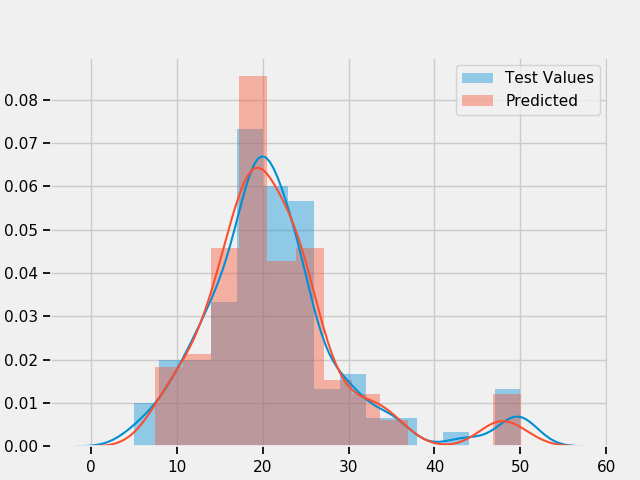

/home/harperes/miniconda3/envs/ml/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [20]:
y_preds = model.predict(X_valid_scaled)
sns.set_context("notebook", font_scale=1)
plt.figure()
sns.distplot(y_valid, label="Test Values")
sns.distplot(y_preds, label="Predicted")
plt.legend()

<IPython.core.display.Javascript object>


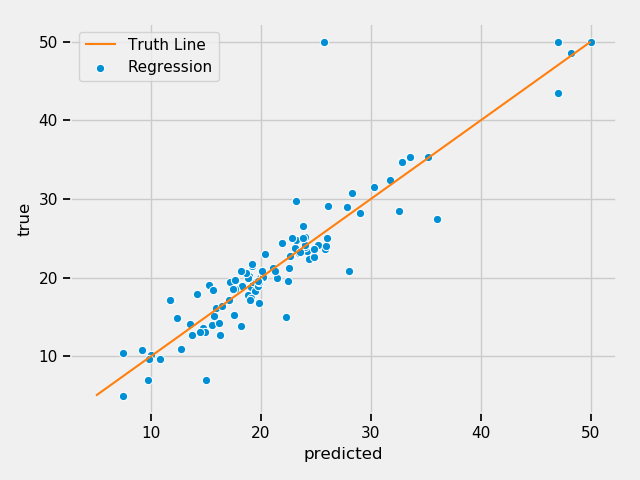

In [21]:
y_pred = model.predict(X_valid_scaled.values)
fig = plt.figure()
ax = fig.add_subplot(111)
sns.scatterplot(y_pred.reshape(-1), y_valid, ax=ax,
                label='Regression')
ax.plot([np.nanmin(y_valid), np.nanmax(y_valid)],
        [np.nanmin(y_valid), np.nanmax(y_valid)],
        color='tab:orange', label="Truth Line")
ax.set_xlabel("predicted")
ax.set_ylabel("true")
plt.legend()
plt.tight_layout()
plt.show()

I'm very happy with that model...let's try a neural net

Below we define the function to create the baseline model to be evaluated.

It is a simple model that has a single fully connected hidden layer with the same number of neurons as input attributes (13).

The network uses good practices such as the rectifier activation function for the hidden layer.

**No activation function is used for the output layer because it is a regression problem and we are interested in predicting numerical values directly without transform.**

The efficient ADAM optimization algorithm is used and a mean squared error loss function is optimized. This will be the same metric that we will use to evaluate the performance of the model. It is a desirable metric because by taking the square root gives us an error value we can directly understand in the context of the problem (thousands of dollars).

In [22]:
model = Sequential()
model.add(Dense(13, input_dim=13, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, activation='linear'))

from keras import backend as K

def coeff_determination(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_pred)))
    return ( 1 - SS_res/(SS_tot + K.epsilon()))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=[coeff_determination])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 13)                182       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 14        
Total params: 196
Trainable params: 196
Non-trainable params: 0
_________________________________________________________________


In [23]:
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=10, verbose=1)
history = model.fit(X_train_scaled.values, y_train, batch_size=10, epochs=1000,
                    validation_split=0.2, shuffle=True, verbose=1, callbacks=[early_stop])

Train on 324 samples, validate on 82 samples
Epoch 1/1000
324/324 [==============================] - 1s 3ms/step - loss: 607.7470 - coeff_determination: -0.0025 - val_loss: 541.8435 - val_coeff_determination: -0.0031
Epoch 2/1000
324/324 [==============================] - 0s 127us/step - loss: 592.3467 - coeff_determination: -0.0064 - val_loss: 526.4460 - val_coeff_determination: -0.0066
Epoch 3/1000
324/324 [==============================] - 0s 130us/step - loss: 575.1020 - coeff_determination: -0.0116 - val_loss: 508.7111 - val_coeff_determination: -0.0107
Epoch 4/1000
324/324 [==============================] - 0s 129us/step - loss: 555.7101 - coeff_determination: -0.0180 - val_loss: 489.1743 - val_coeff_determination: -0.0163
Epoch 5/1000
324/324 [==============================] - 0s 130us/step - loss: 534.6443 - coeff_determination: -0.0240 - val_loss: 468.3926 - val_coeff_determination: -0.0222
Epoch 6/1000
324/324 [==============================] - 0s 131us/step - loss: 511.8633 

324/324 [==============================] - 0s 138us/step - loss: 23.5947 - coeff_determination: 0.6546 - val_loss: 30.2842 - val_coeff_determination: 0.3637
Epoch 49/1000
324/324 [==============================] - 0s 135us/step - loss: 23.3066 - coeff_determination: 0.6170 - val_loss: 29.9964 - val_coeff_determination: 0.3654
Epoch 50/1000
324/324 [==============================] - 0s 145us/step - loss: 23.1246 - coeff_determination: 0.6019 - val_loss: 29.9615 - val_coeff_determination: 0.3659
Epoch 51/1000
324/324 [==============================] - 0s 128us/step - loss: 22.9148 - coeff_determination: 0.6725 - val_loss: 29.7172 - val_coeff_determination: 0.3654
Epoch 52/1000
324/324 [==============================] - 0s 129us/step - loss: 22.6443 - coeff_determination: 0.6942 - val_loss: 29.8355 - val_coeff_determination: 0.3671
Epoch 53/1000
324/324 [==============================] - 0s 133us/step - loss: 22.4437 - coeff_determination: 0.6217 - val_loss: 29.6669 - val_coeff_determinat

Epoch 96/1000
324/324 [==============================] - 0s 126us/step - loss: 16.9397 - coeff_determination: 0.7764 - val_loss: 24.6025 - val_coeff_determination: 0.4491
Epoch 97/1000
324/324 [==============================] - 0s 128us/step - loss: 16.7927 - coeff_determination: 0.7642 - val_loss: 24.2063 - val_coeff_determination: 0.4511
Epoch 98/1000
324/324 [==============================] - 0s 129us/step - loss: 16.7038 - coeff_determination: 0.7617 - val_loss: 24.2716 - val_coeff_determination: 0.4557
Epoch 99/1000
324/324 [==============================] - 0s 130us/step - loss: 16.5811 - coeff_determination: 0.7508 - val_loss: 24.1254 - val_coeff_determination: 0.4571
Epoch 100/1000
324/324 [==============================] - 0s 130us/step - loss: 16.5221 - coeff_determination: 0.7507 - val_loss: 23.8068 - val_coeff_determination: 0.4619
Epoch 101/1000
324/324 [==============================] - 0s 137us/step - loss: 16.4458 - coeff_determination: 0.7510 - val_loss: 23.7880 - val_

Epoch 144/1000
324/324 [==============================] - 0s 129us/step - loss: 13.9623 - coeff_determination: 0.6837 - val_loss: 20.4097 - val_coeff_determination: 0.5345
Epoch 145/1000
324/324 [==============================] - 0s 128us/step - loss: 13.9761 - coeff_determination: 0.7874 - val_loss: 20.4576 - val_coeff_determination: 0.5318
Epoch 146/1000
324/324 [==============================] - 0s 134us/step - loss: 13.8751 - coeff_determination: 0.8056 - val_loss: 20.2311 - val_coeff_determination: 0.5370
Epoch 147/1000
324/324 [==============================] - 0s 133us/step - loss: 13.8808 - coeff_determination: 0.7749 - val_loss: 20.1414 - val_coeff_determination: 0.5405
Epoch 148/1000
324/324 [==============================] - 0s 130us/step - loss: 13.8032 - coeff_determination: 0.7331 - val_loss: 20.1293 - val_coeff_determination: 0.5416
Epoch 149/1000
324/324 [==============================] - 0s 133us/step - loss: 13.7466 - coeff_determination: 0.7901 - val_loss: 20.0294 - 

324/324 [==============================] - 0s 132us/step - loss: 12.2829 - coeff_determination: 0.8080 - val_loss: 17.8511 - val_coeff_determination: 0.6005
Epoch 192/1000
324/324 [==============================] - 0s 137us/step - loss: 12.1494 - coeff_determination: 0.8091 - val_loss: 17.6811 - val_coeff_determination: 0.6031
Epoch 193/1000
324/324 [==============================] - 0s 140us/step - loss: 12.1685 - coeff_determination: 0.8217 - val_loss: 17.7489 - val_coeff_determination: 0.6008
Epoch 194/1000
324/324 [==============================] - 0s 137us/step - loss: 12.1554 - coeff_determination: 0.8158 - val_loss: 17.6083 - val_coeff_determination: 0.6057
Epoch 195/1000
324/324 [==============================] - 0s 144us/step - loss: 12.1180 - coeff_determination: 0.8145 - val_loss: 17.7518 - val_coeff_determination: 0.6070
Epoch 196/1000
324/324 [==============================] - 0s 143us/step - loss: 12.0682 - coeff_determination: 0.8355 - val_loss: 17.4401 - val_coeff_deter

Epoch 239/1000
324/324 [==============================] - 0s 129us/step - loss: 10.8995 - coeff_determination: 0.8242 - val_loss: 15.9565 - val_coeff_determination: 0.6551
Epoch 240/1000
324/324 [==============================] - 0s 135us/step - loss: 10.7247 - coeff_determination: 0.8324 - val_loss: 15.8558 - val_coeff_determination: 0.6526
Epoch 241/1000
324/324 [==============================] - 0s 143us/step - loss: 10.6964 - coeff_determination: 0.8117 - val_loss: 15.7687 - val_coeff_determination: 0.6538
Epoch 242/1000
324/324 [==============================] - 0s 137us/step - loss: 10.7119 - coeff_determination: 0.8232 - val_loss: 15.7091 - val_coeff_determination: 0.6563
Epoch 243/1000
324/324 [==============================] - 0s 135us/step - loss: 10.6865 - coeff_determination: 0.8245 - val_loss: 15.6287 - val_coeff_determination: 0.6562
Epoch 244/1000
324/324 [==============================] - 0s 129us/step - loss: 10.6665 - coeff_determination: 0.8484 - val_loss: 15.6497 - 

Epoch 287/1000
324/324 [==============================] - 0s 134us/step - loss: 9.7645 - coeff_determination: 0.8654 - val_loss: 14.7066 - val_coeff_determination: 0.6791
Epoch 288/1000
324/324 [==============================] - 0s 140us/step - loss: 9.7854 - coeff_determination: 0.8184 - val_loss: 14.8044 - val_coeff_determination: 0.6783
Epoch 289/1000
324/324 [==============================] - 0s 142us/step - loss: 9.7545 - coeff_determination: 0.8337 - val_loss: 14.5914 - val_coeff_determination: 0.6806
Epoch 290/1000
324/324 [==============================] - 0s 139us/step - loss: 9.7600 - coeff_determination: 0.8271 - val_loss: 14.7719 - val_coeff_determination: 0.6779
Epoch 291/1000
324/324 [==============================] - 0s 132us/step - loss: 9.8121 - coeff_determination: 0.8568 - val_loss: 14.5274 - val_coeff_determination: 0.6823
Epoch 292/1000
324/324 [==============================] - 0s 131us/step - loss: 9.7272 - coeff_determination: 0.8249 - val_loss: 14.6408 - val_co

<IPython.core.display.Javascript object>


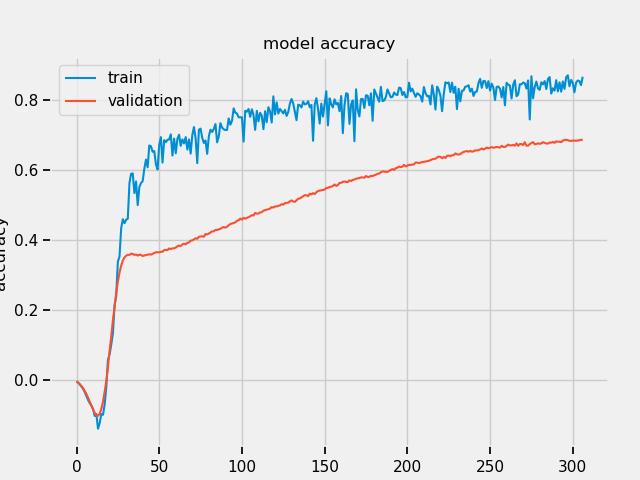

<IPython.core.display.Javascript object>


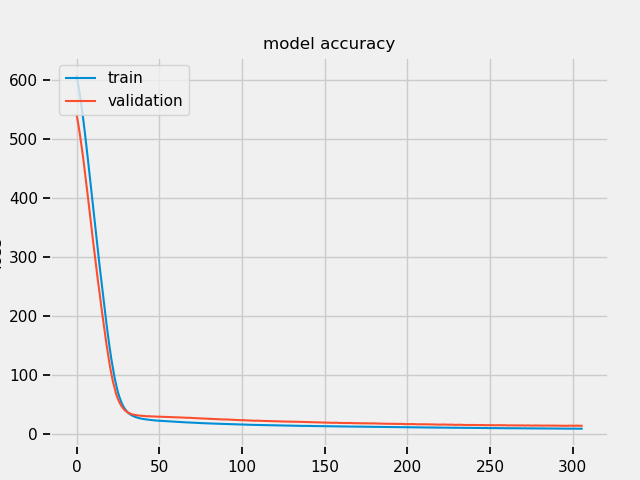

In [24]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(history.history['coeff_determination'])
ax.plot(history.history['val_coeff_determination'])
ax.set_title('model accuracy')
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
ax.legend(['train', 'validation'], loc='upper left')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('model accuracy')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend(['train', 'validation'], loc='upper left')
plt.show()

Note that the accuracy seems to be a silly measurement for this dataset...not sure why

100/100 [==============================] - 0s 31us/step
['loss', 'coeff_determination']
[11.433138427734375, 0.8814644193649293]


<IPython.core.display.Javascript object>


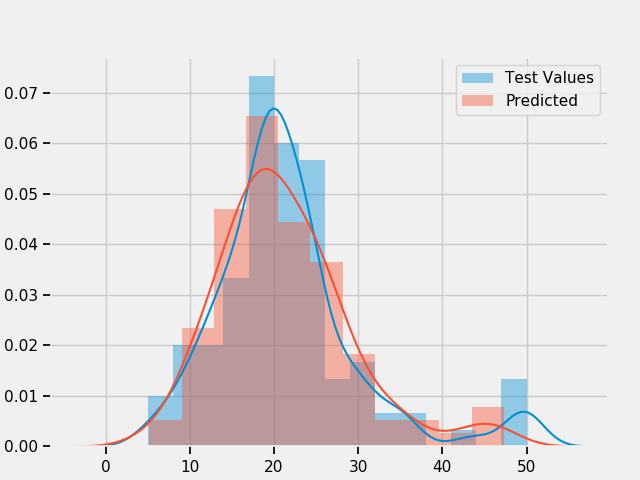

/home/harperes/miniconda3/envs/ml/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [25]:
# evaluate(model, dataframe.columns[:13],
#          X_train_scaled, X_valid_scaled, y_train, y_valid)
score = model.evaluate(X_valid_scaled.values, y_valid)
print(model.metrics_names)
print(score)
y_preds = model.predict(X_valid_scaled.values)
sns.set_context("notebook", font_scale=1)
plt.figure()
sns.distplot(y_valid, label="Test Values")
sns.distplot(y_preds, label="Predicted")
plt.legend()

In [26]:
# quick and dirty comparison

def evaluate_ann(model, X_train, X_valid, y_train, y_valid):
    """Mean absolute percentage error"""
    
    # Make predictions
    train_pred = model.predict(X_train.values)
    valid_pred = model.predict(X_valid.values)
    
    # Get metrics
    train_rmse, valid_rmse, train_mape, valid_mape = metrics(train_pred, valid_pred,
                                                             y_train, y_valid)
    
    print(f'Training:   rmse = {round(train_rmse, 2)} \t mape = {round(train_mape, 2)}')
    print(f'Validation: rmse = {round(valid_rmse, 2)} \t mape = {round(valid_mape, 2)}')

In [27]:
evaluate_ann(model, X_train_scaled, X_valid_scaled, y_train, y_valid)

Training:   rmse = 3.22 	 mape = 50.66
Validation: rmse = 3.38 	 mape = 47.35


<IPython.core.display.Javascript object>


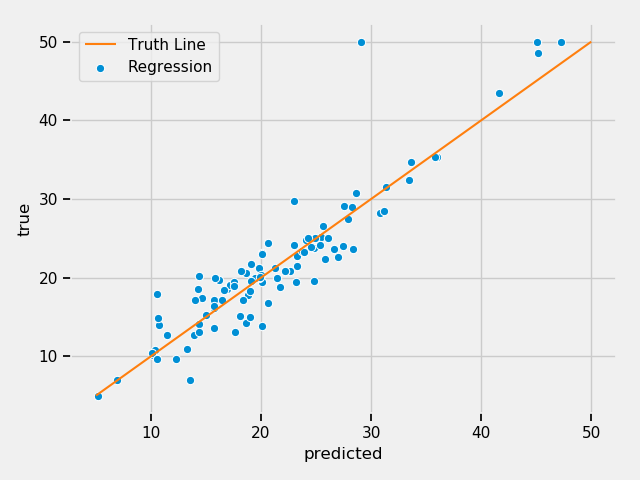

In [28]:
y_pred = model.predict(X_valid_scaled.values)
fig = plt.figure()
ax = fig.add_subplot(111)
sns.scatterplot(y_pred.reshape(-1), y_valid, ax=ax,
                label='Regression')
ax.plot([np.nanmin(y_valid), np.nanmax(y_valid)],
        [np.nanmin(y_valid), np.nanmax(y_valid)],
        color='tab:orange', label="Truth Line")
ax.set_xlabel("predicted")
ax.set_ylabel("true")
plt.legend()
plt.tight_layout()
plt.show()

Very nice performance with the simple model!

Much more complicated model

In [243]:
from keras.layers import Dropout
from keras import backend as K

def coeff_determination(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_pred)))
    return ( 1 - SS_res/(SS_tot + K.epsilon()))

model = Sequential()
model.add(Dense(20, input_dim=13, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.1))
# model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=[coeff_determination])
model.summary()

early_stop = EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=10, verbose=1)
history = model.fit(X_train_scaled.values, y_train, batch_size=10, epochs=1000,
                    validation_split=0.2, shuffle=True, verbose=1, callbacks=[early_stop])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_71 (Dense)             (None, 20)                280       
_________________________________________________________________
dropout_31 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_72 (Dense)             (None, 8)                 168       
_________________________________________________________________
dropout_32 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_73 (Dense)             (None, 1)                 9         
Total params: 457
Trainable params: 457
Non-trainable params: 0
_________________________________________________________________
Train on 324 samples, validate on 82 samples
Epoch 1/1000
324/324 [==============================] - 0s - loss: 592.0359 - coeff_determination: 

dict_keys(['val_loss', 'val_coeff_determination', 'loss', 'coeff_determination'])


<IPython.core.display.Javascript object>


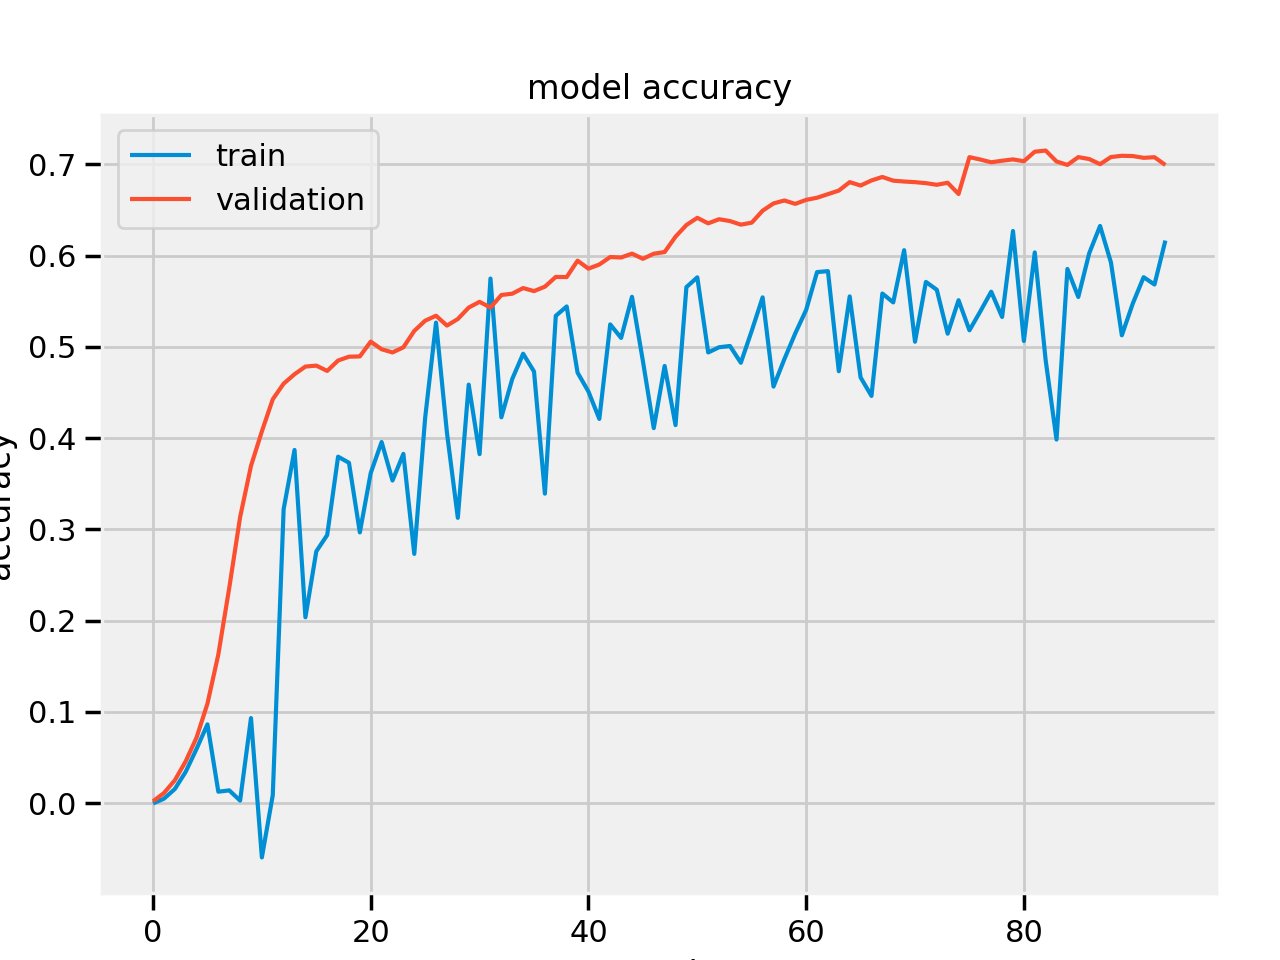

<IPython.core.display.Javascript object>


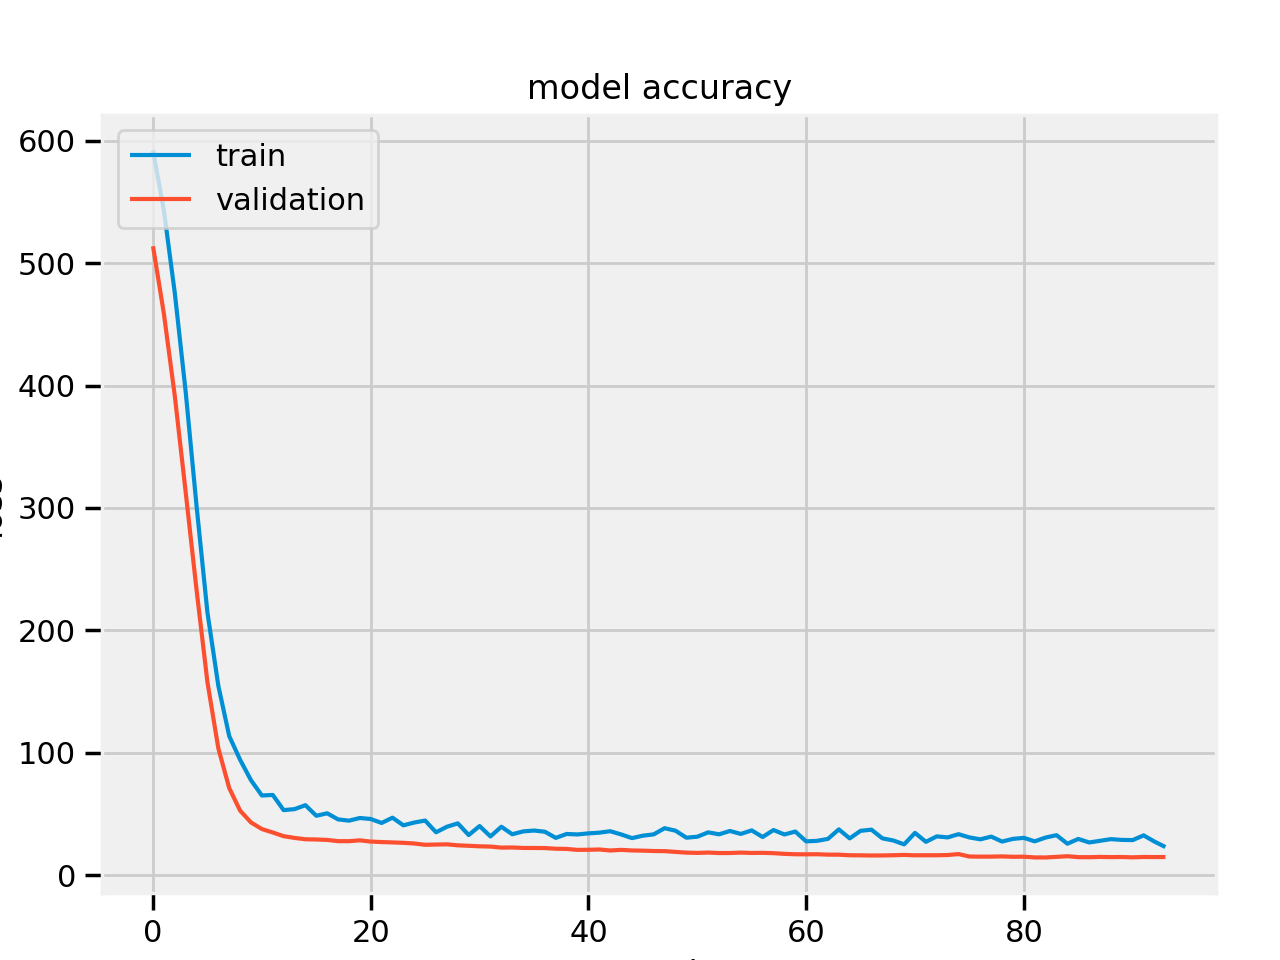

 32/100 [========>.....................] - ETA: 0s['loss', 'coeff_determination']
[15.615303955078126, 0.84881564855575564]


<IPython.core.display.Javascript object>


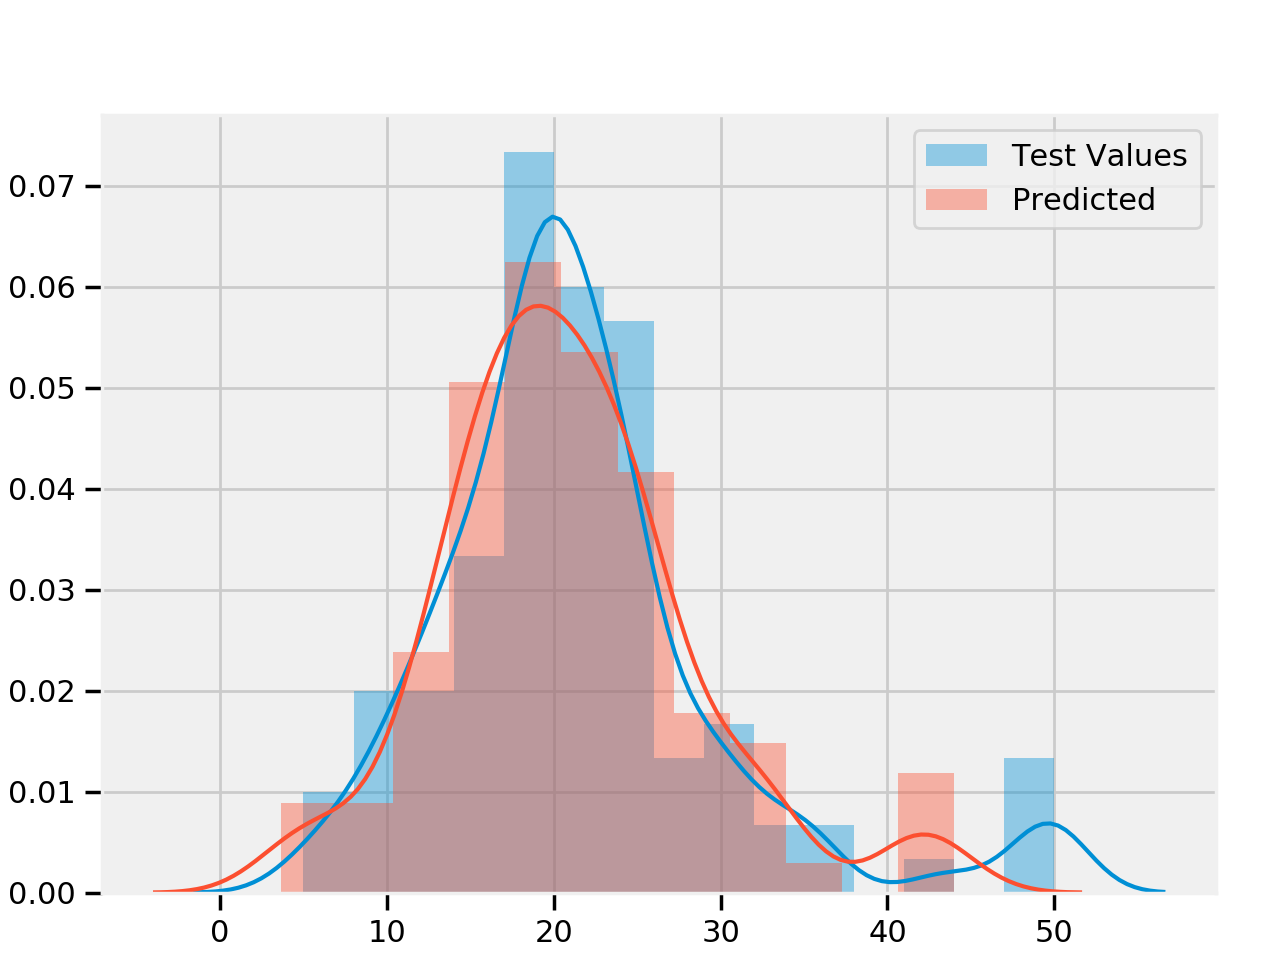

In [244]:
print(history.history.keys())
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(history.history['coeff_determination'])
ax.plot(history.history['val_coeff_determination'])
ax.set_title('model accuracy')
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
ax.legend(['train', 'validation'], loc='upper left')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('model accuracy')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend(['train', 'validation'], loc='upper left')
plt.show()

score = model.evaluate(X_valid_scaled.values, y_valid)
print(model.metrics_names)
print(score)
y_preds = model.predict(X_valid_scaled.values)
sns.set_context("notebook", font_scale=1)
plt.figure()
sns.distplot(y_valid, label="Test Values")
sns.distplot(y_preds, label="Predicted")
plt.legend()

Training:   rmse = 3.43 	 mape = 48.23
Validation: rmse = 3.95 	 mape = 46.31


<IPython.core.display.Javascript object>


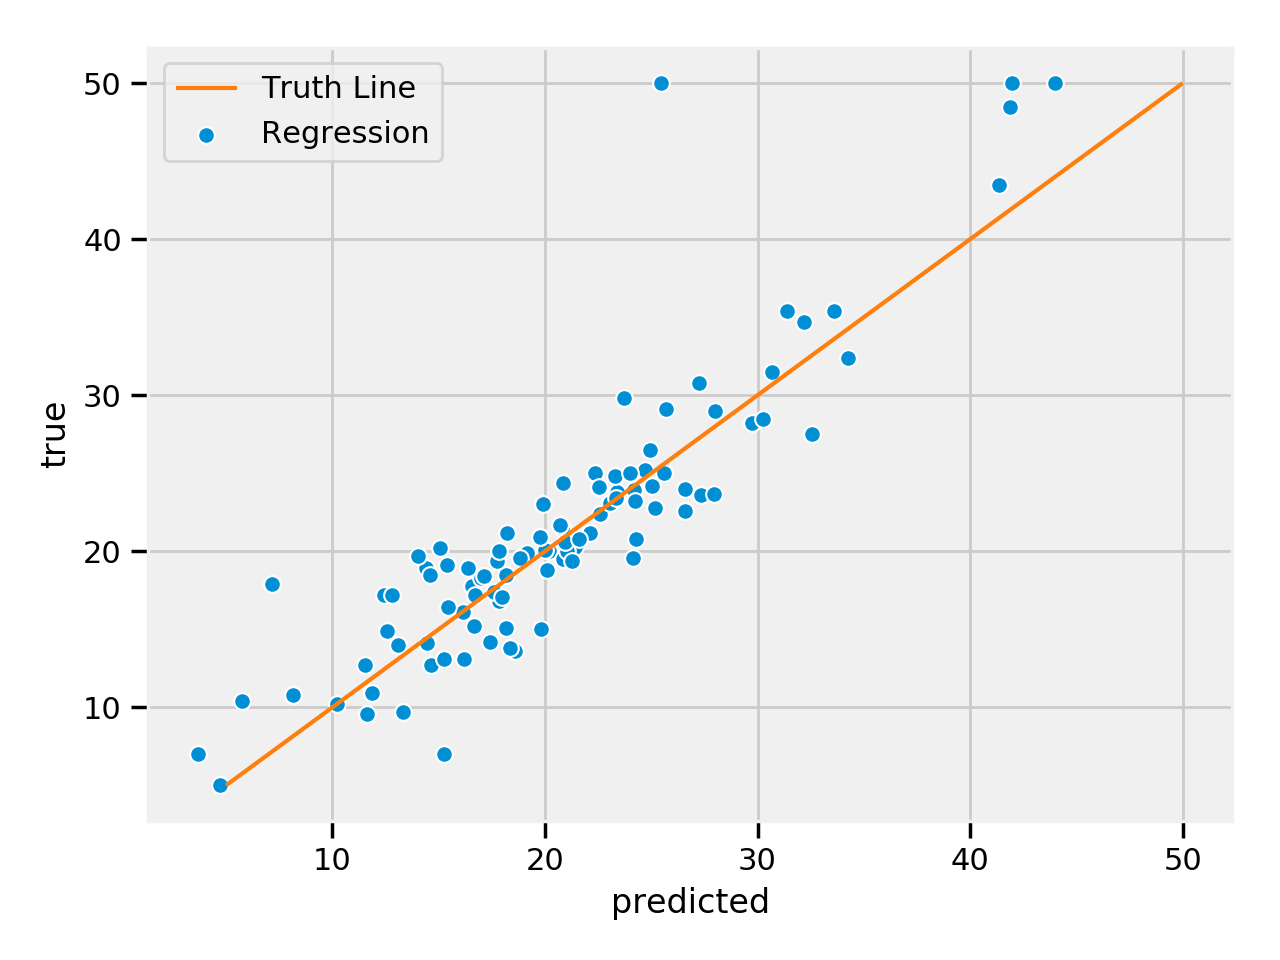

In [245]:
evaluate_ann(model, X_train_scaled, X_valid_scaled, y_train, y_valid)

y_pred = model.predict(X_valid_scaled.values)
fig = plt.figure()
ax = fig.add_subplot(111)
sns.scatterplot(y_pred.reshape(-1), y_valid, ax=ax,
                label='Regression')
ax.plot([np.nanmin(y_valid), np.nanmax(y_valid)],
        [np.nanmin(y_valid), np.nanmax(y_valid)],
        color='tab:orange', label="Truth Line")
ax.set_xlabel("predicted")
ax.set_ylabel("true")
plt.legend()
plt.tight_layout()
plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_74 (Dense)             (None, 13)                182       
_________________________________________________________________
dropout_33 (Dropout)         (None, 13)                0         
_________________________________________________________________
dense_75 (Dense)             (None, 8)                 112       
_________________________________________________________________
dropout_34 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_76 (Dense)             (None, 6)                 54        
_________________________________________________________________
dense_77 (Dense)             (None, 4)                 28        
_________________________________________________________________
dense_78 (Dense)             (None, 1)                 5         
Total para

324/324 [==============================] - 0s - loss: 19.4959 - acc: 0.0123 - val_loss: 12.6647 - val_acc: 0.0000e+00
Epoch 116/1000
324/324 [==============================] - 0s - loss: 16.0546 - acc: 0.0123 - val_loss: 12.5254 - val_acc: 0.0122
Epoch 117/1000
324/324 [==============================] - 0s - loss: 18.1999 - acc: 0.0154 - val_loss: 12.9342 - val_acc: 0.0122
Epoch 118/1000
324/324 [==============================] - 0s - loss: 20.2031 - acc: 0.0062 - val_loss: 12.5499 - val_acc: 0.0122
Epoch 119/1000
324/324 [==============================] - 0s - loss: 17.1130 - acc: 0.0093 - val_loss: 13.0623 - val_acc: 0.0122
Epoch 120/1000
324/324 [==============================] - 0s - loss: 14.2140 - acc: 0.0185 - val_loss: 13.0136 - val_acc: 0.0122
Epoch 00119: early stopping


<IPython.core.display.Javascript object>


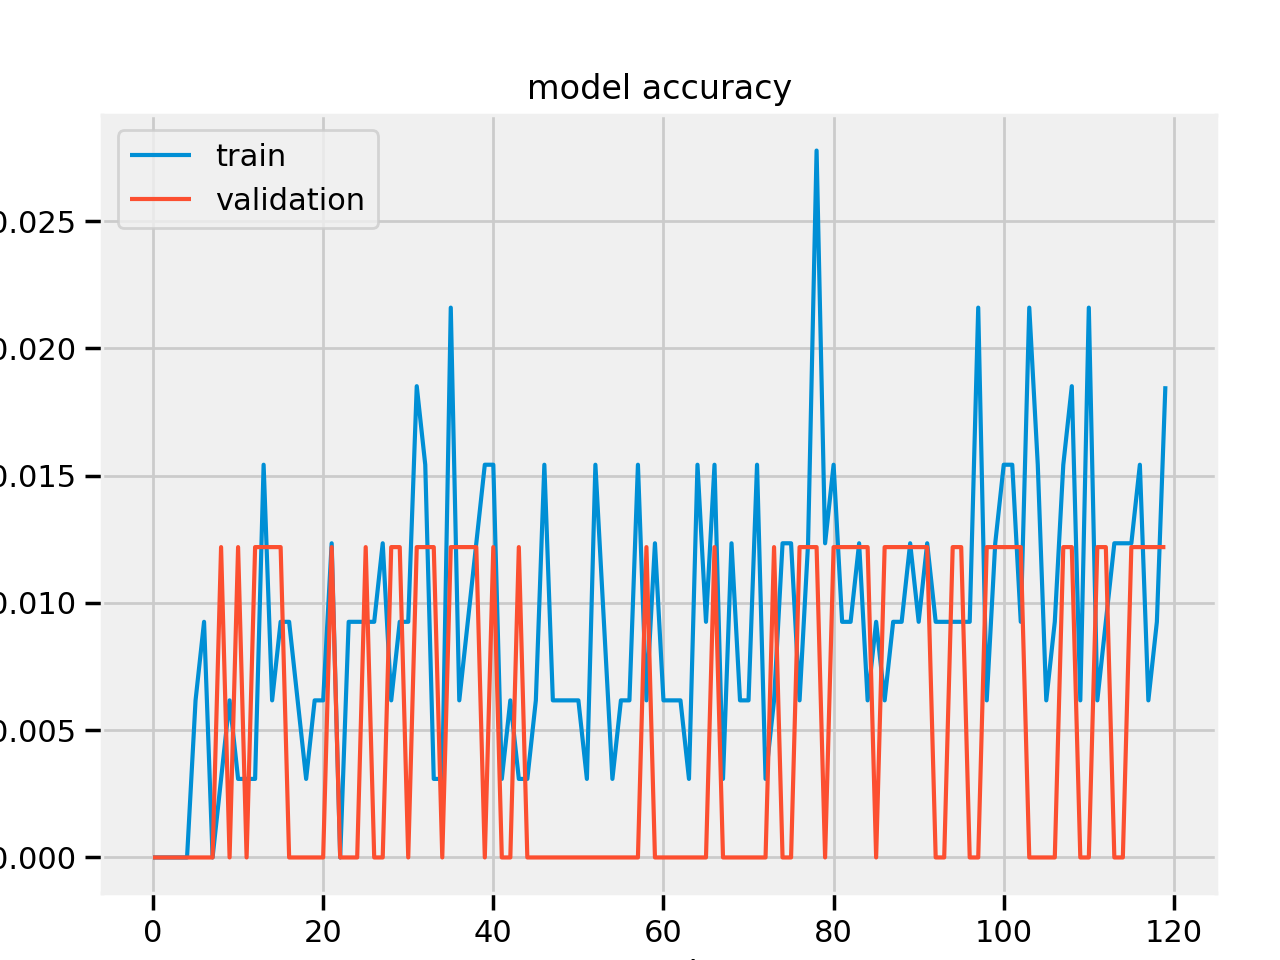

<IPython.core.display.Javascript object>


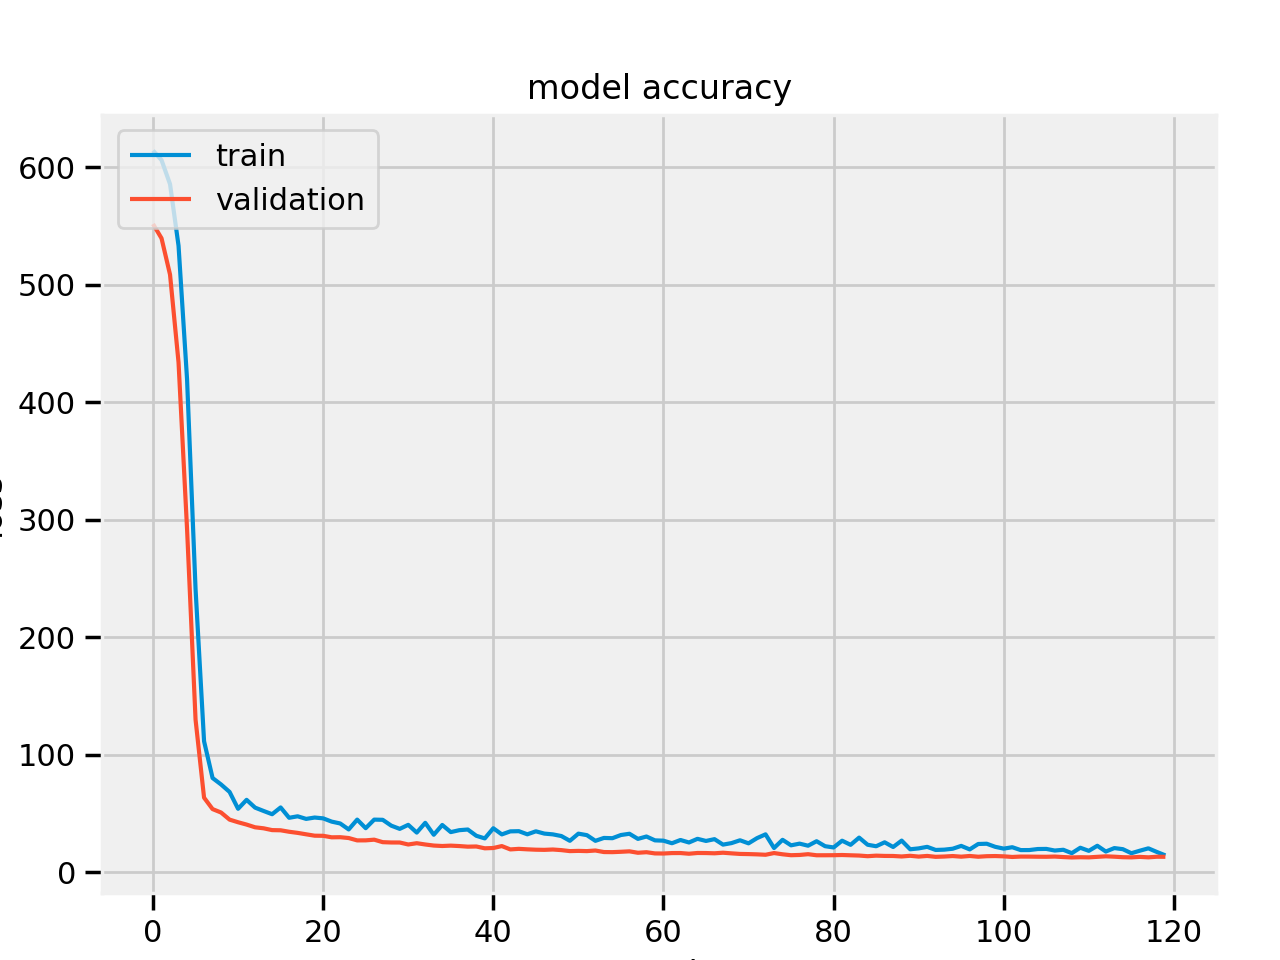

 32/100 [========>.....................] - ETA: 0s['loss', 'acc']
[14.514769897460937, 0.02]


<IPython.core.display.Javascript object>


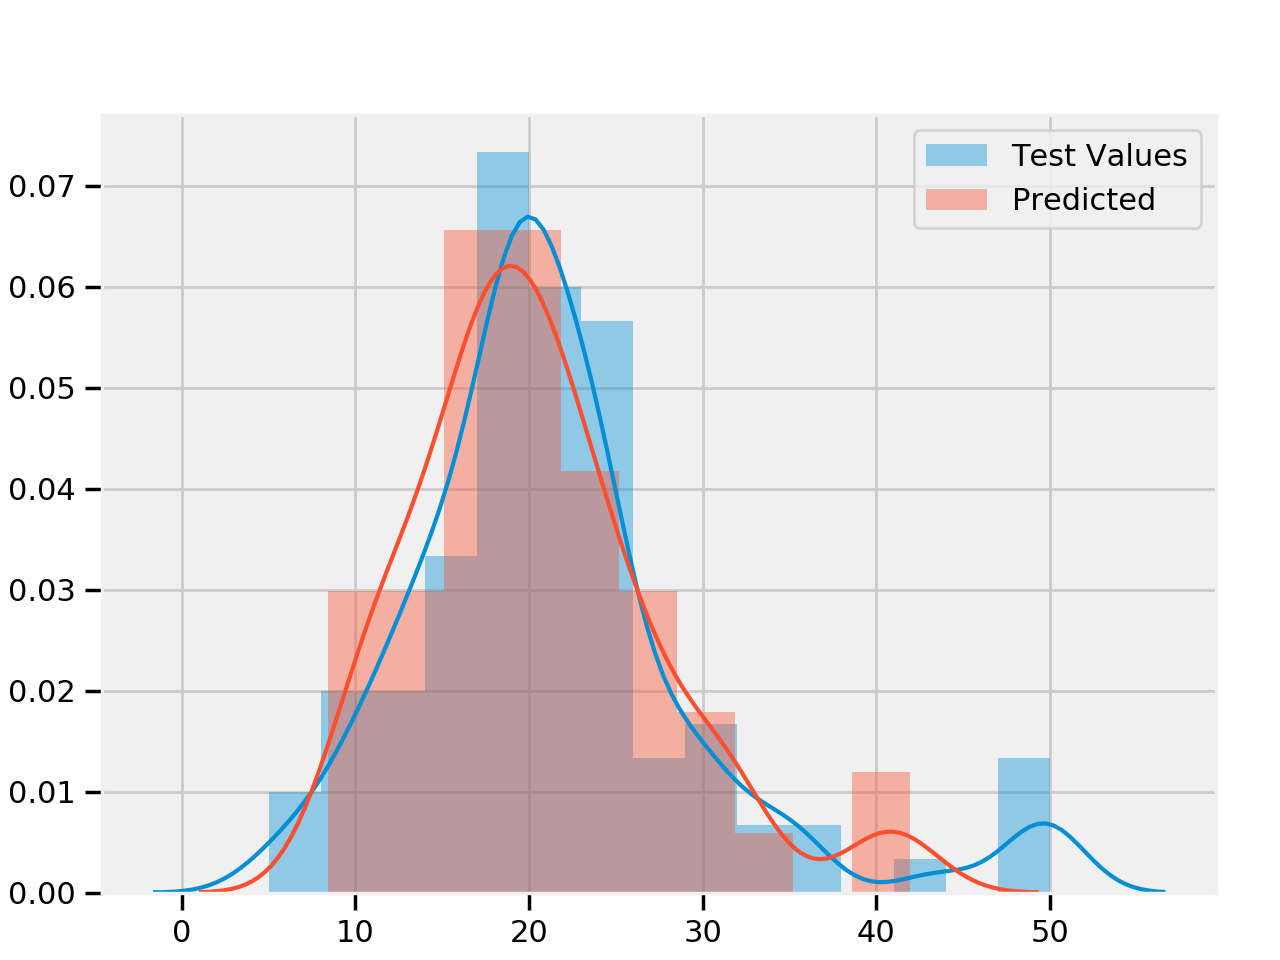

In [246]:
from keras.layers import Dropout
model = Sequential()
model.add(Dense(13, input_dim=13, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(6, activation='relu'))
model.add(Dense(4, activation='relu'))
# model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=[coeff_determination])
model.summary()

early_stop = EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=10, verbose=1)
history = model.fit(X_train_scaled.values, y_train, batch_size=10, epochs=1000,
                    validation_split=0.2, shuffle=True, verbose=1, callbacks=[early_stop])

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(history.history['coeff_determination'])
ax.plot(history.history['val_coeff_determination'])
ax.set_title('model accuracy')
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
ax.legend(['train', 'validation'], loc='upper left')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('model accuracy')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend(['train', 'validation'], loc='upper left')
plt.show()

score = model.evaluate(X_valid_scaled.values, y_valid)
print(model.metrics_names)
print(score)
y_preds = model.predict(X_valid_scaled.values)
sns.set_context("notebook", font_scale=1)
plt.figure()
sns.distplot(y_valid, label="Test Values")
sns.distplot(y_preds, label="Predicted")
plt.legend()

<IPython.core.display.Javascript object>


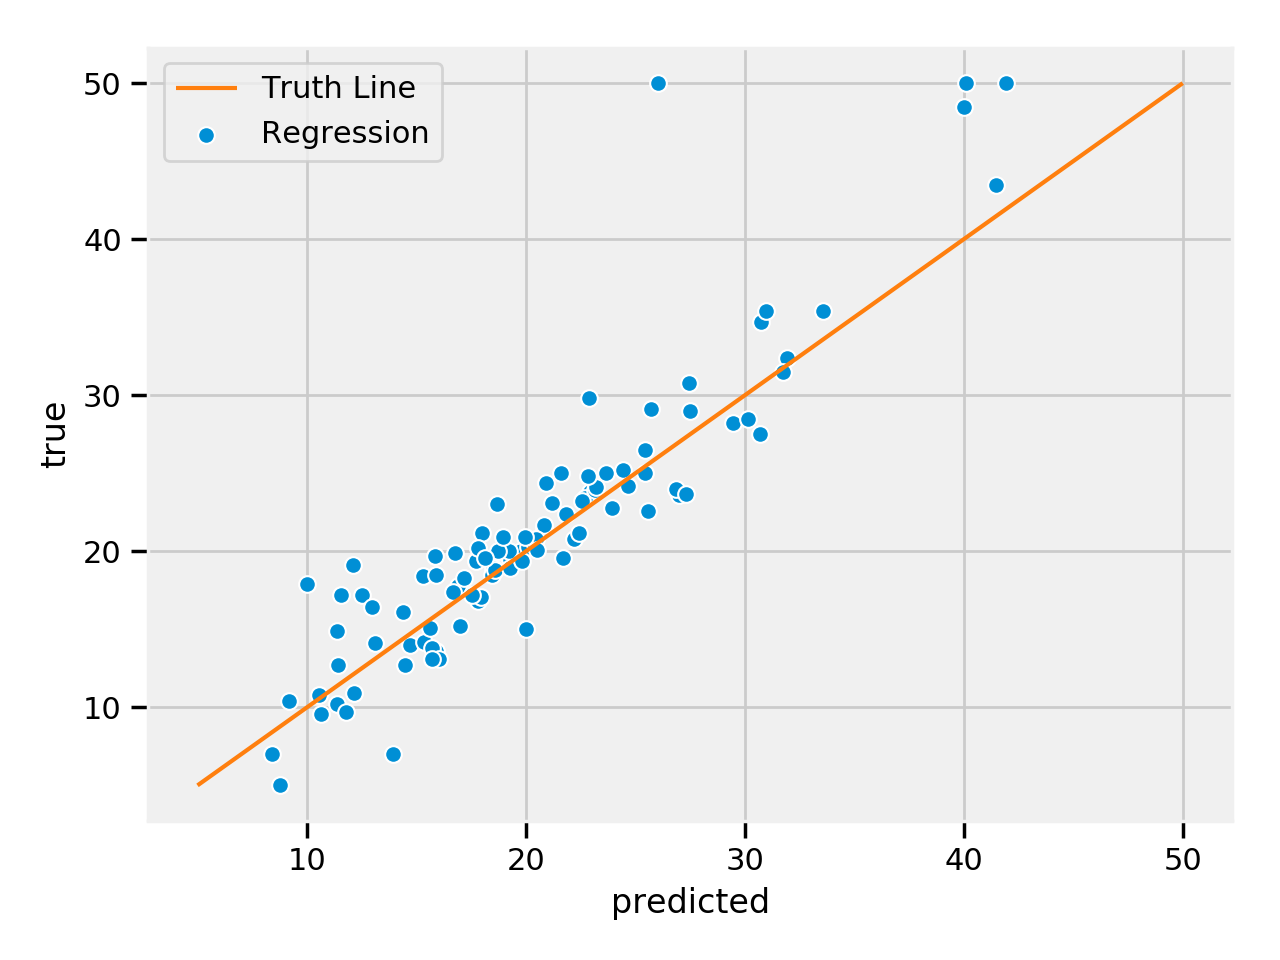

In [247]:
y_pred = model.predict(X_valid_scaled.values)
fig = plt.figure()
ax = fig.add_subplot(111)
sns.scatterplot(y_pred.reshape(-1), y_valid, ax=ax,
                label='Regression')
ax.plot([np.nanmin(y_valid), np.nanmax(y_valid)],
        [np.nanmin(y_valid), np.nanmax(y_valid)],
        color='tab:orange', label="Truth Line")
ax.set_xlabel("predicted")
ax.set_ylabel("true")
plt.legend()
plt.tight_layout()
plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_79 (Dense)             (None, 13)                182       
_________________________________________________________________
dropout_35 (Dropout)         (None, 13)                0         
_________________________________________________________________
dense_80 (Dense)             (None, 8)                 112       
_________________________________________________________________
dropout_36 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_81 (Dense)             (None, 6)                 54        
_________________________________________________________________
dropout_37 (Dropout)         (None, 6)                 0         
_________________________________________________________________
dense_82 (Dense)             (None, 4)                 28        
__________

<IPython.core.display.Javascript object>


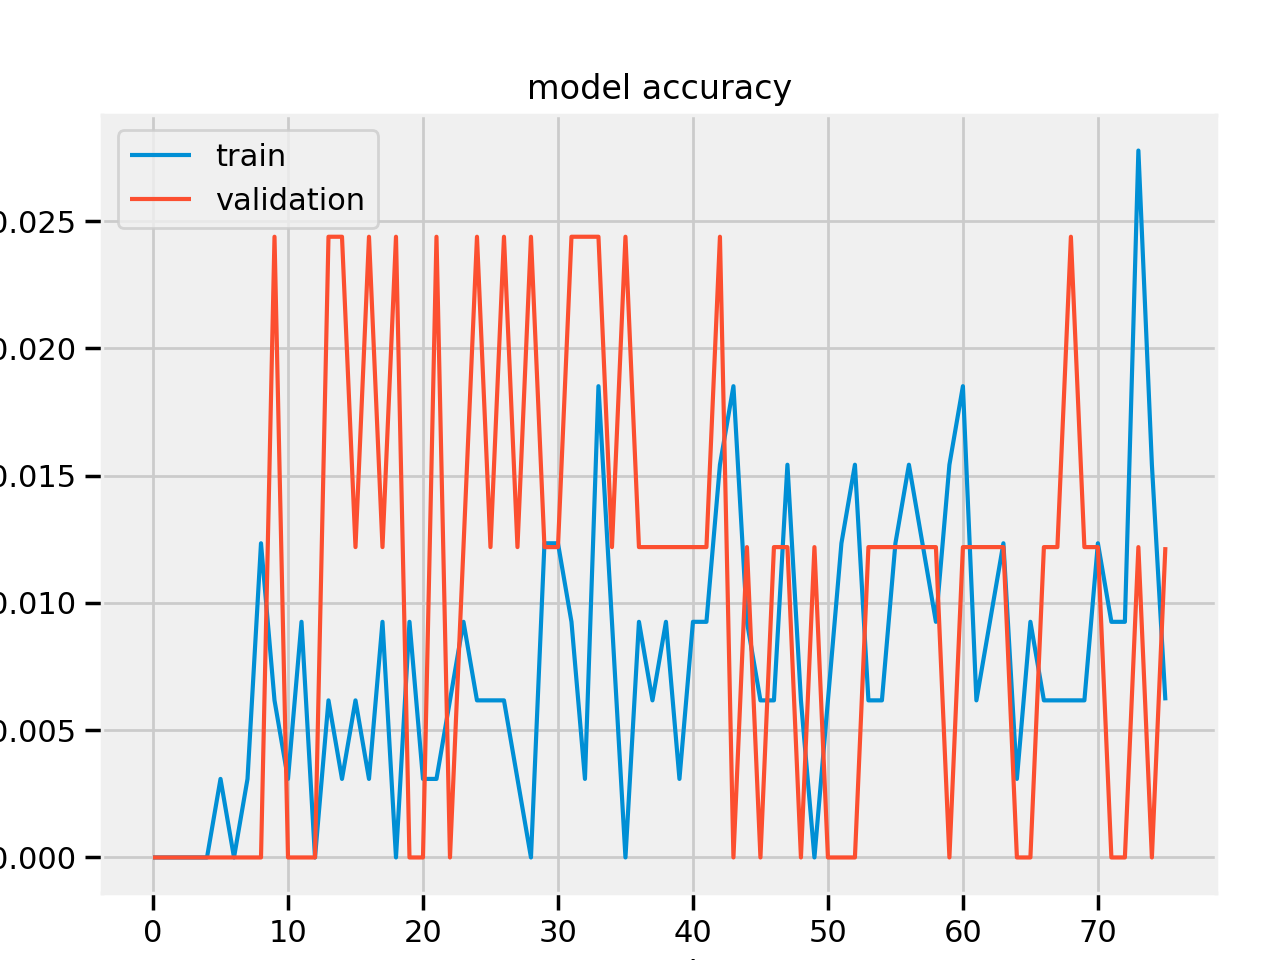

<IPython.core.display.Javascript object>


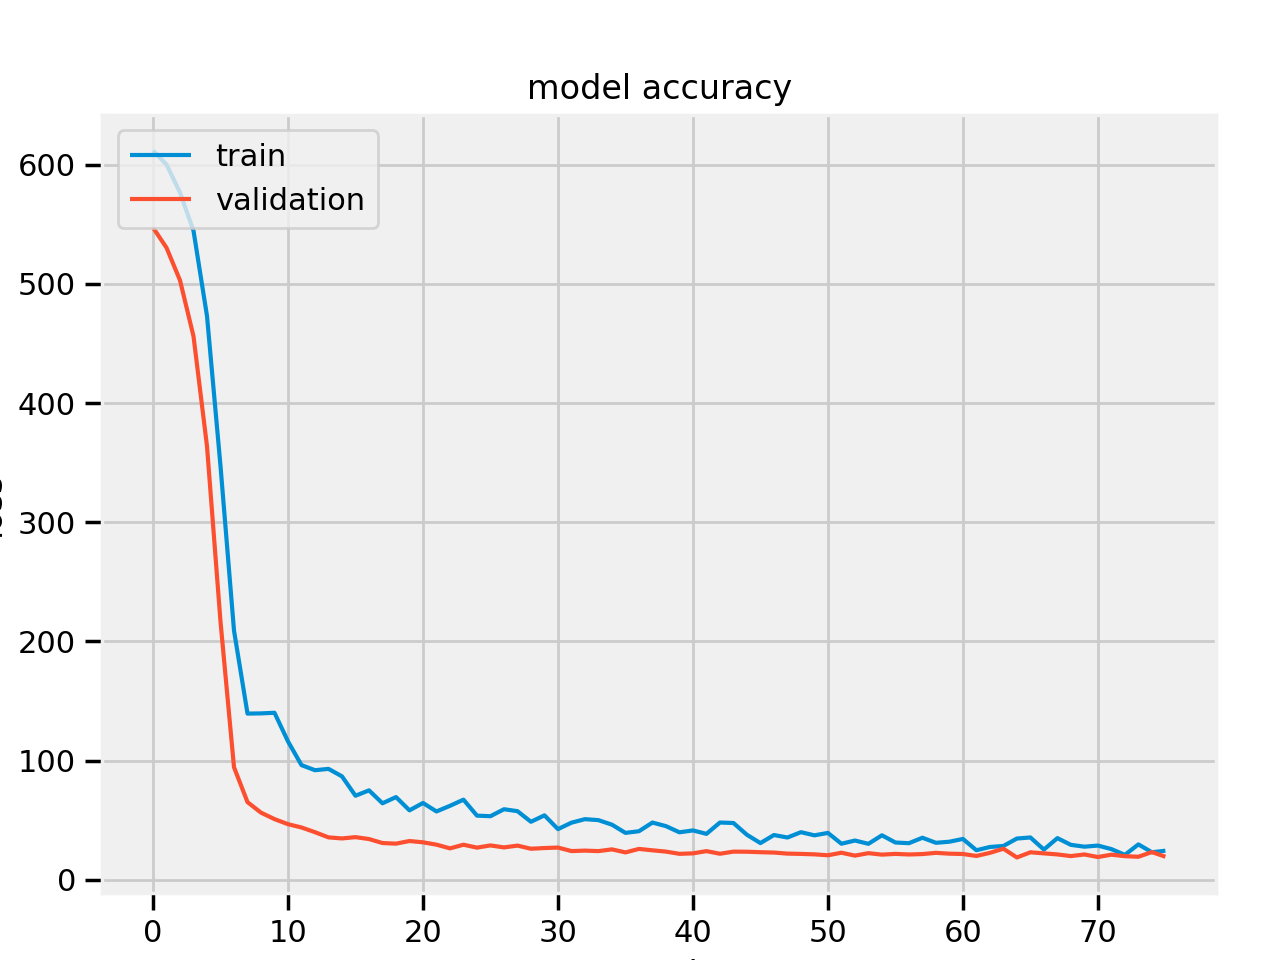

 32/100 [========>.....................] - ETA: 0s['loss', 'acc']
[20.815510864257813, 0.01]


<IPython.core.display.Javascript object>


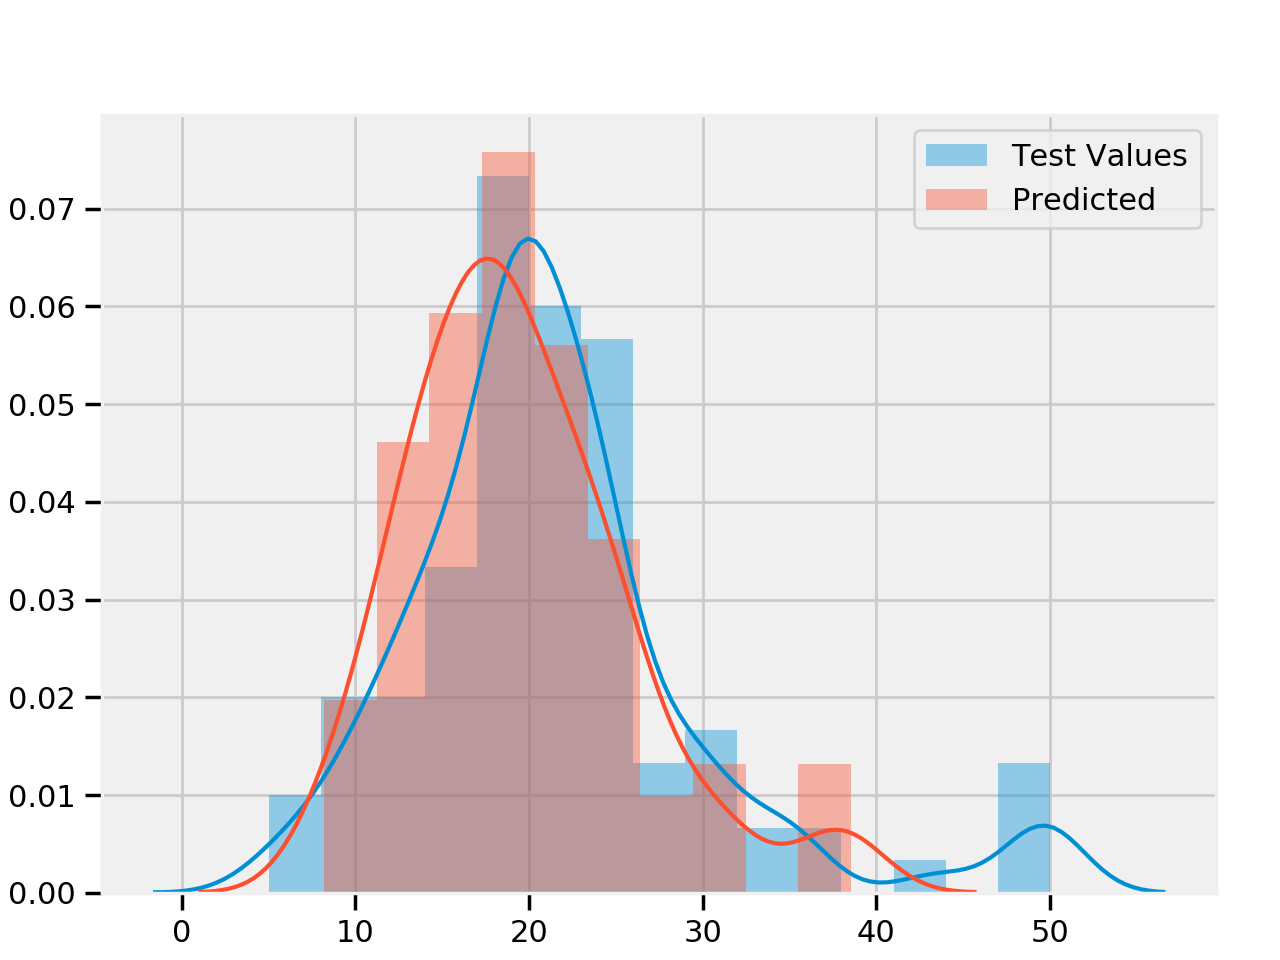

In [248]:
from keras.layers import Dropout
model = Sequential()
model.add(Dense(13, input_dim=13, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(6, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(4, activation='relu'))
# model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=[coeff_determination])
model.summary()

early_stop = EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=10, verbose=1)
history = model.fit(X_train_scaled.values, y_train, batch_size=10, epochs=1000,
                    validation_split=0.2, shuffle=True, verbose=1, callbacks=[early_stop])

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(history.history['coeff_determination'])
ax.plot(history.history['val_coeff_determination'])
ax.set_title('model accuracy')
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
ax.legend(['train', 'validation'], loc='upper left')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('model accuracy')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend(['train', 'validation'], loc='upper left')
plt.show()

score = model.evaluate(X_valid_scaled.values, y_valid)
print(model.metrics_names)
print(score)
y_preds = model.predict(X_valid_scaled.values)
sns.set_context("notebook", font_scale=1)
plt.figure()
sns.distplot(y_valid, label="Test Values")
sns.distplot(y_preds, label="Predicted")
plt.legend()

<IPython.core.display.Javascript object>


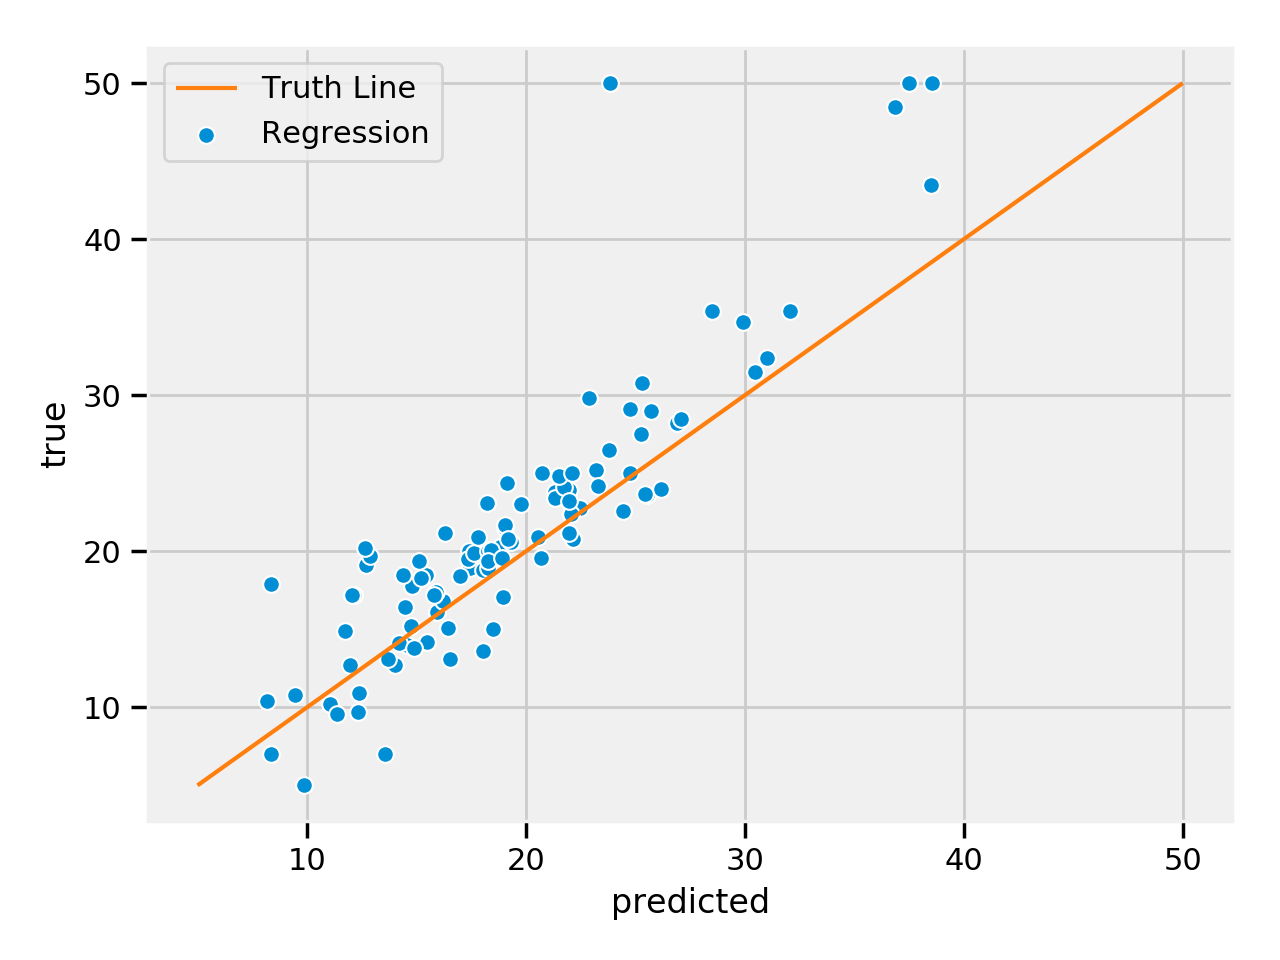

In [249]:
y_pred = model.predict(X_valid_scaled.values)
fig = plt.figure()
ax = fig.add_subplot(111)
sns.scatterplot(y_pred.reshape(-1), y_valid, ax=ax,
                label='Regression')
ax.plot([np.nanmin(y_valid), np.nanmax(y_valid)],
        [np.nanmin(y_valid), np.nanmax(y_valid)],
        color='tab:orange', label="Truth Line")
ax.set_xlabel("predicted")
ax.set_ylabel("true")
plt.legend()
plt.tight_layout()
plt.show()

# OLD

In [113]:
# define base model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(13, input_dim=13, kernel_initializer='normal', activation='relu'))
#     model.add(Dense(13, input_dim=13, kernel_initializer='normal', activation='tanh'))
    model.add(Dense(1, kernel_initializer='normal', activation='linear'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

The Keras wrapper object for use in scikit-learn as a regression estimator is called KerasRegressor. We create an instance and pass it both the name of the function to create the neural network model as well as some parameters to pass along to the fit() function of the model later, such as the number of epochs and batch size. Both of these are set to sensible defaults.

We also initialize the random number generator with a constant random seed, a process we will repeat for each model evaluated in this tutorial. This is an attempt to ensure we compare models consistently.

In [114]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# evaluate model with standardized dataset
estimator = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=5, verbose=0)

The final step is to evaluate this baseline model. We will use 10-fold cross validation to evaluate the model.

In [116]:
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(estimator, X_train_scaled, y_train, cv=kfold)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

KeyError: '[196 358  86 221 118] not in index'

It is almost always good practice to prepare your data before modeling it using a neural network model.

Continuing on from the above baseline model, we can re-evaluate the same model using a standardized version of the input dataset.

We can use scikit-learn’s Pipeline framework to perform the standardization during the model evaluation process, within each fold of the cross validation. This ensures that there is no data leakage from each testset cross validation fold into the training data.

The code below creates a scikit-learn Pipeline that first standardizes the dataset then creates and evaluate the baseline neural network model.

In [ ]:
# evaluate model with standardized dataset
np.random.seed(seed)
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=50, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(pipeline, X, Y, cv=kfold)
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))

A further extension of this section would be to similarly apply a rescaling to the output variable such as normalizing it to the range of 0-1 and use a Sigmoid or similar activation function on the output layer to narrow output predictions to the same range.

# Evaluate Different network topologies

# Deeper (more layers)

In [ ]:
# define the model
def larger_model():
    # create model
    model = Sequential()
    model.add(Dense(13, input_dim=13, kernel_initializer='normal', activation='relu'))
    model.add(Dense(6, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [ ]:
np.random.seed(seed)
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=larger_model, epochs=50, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(pipeline, X, Y, cv=kfold)
print("Larger: %.2f (%.2f) MSE" % (results.mean(), results.std()))

## Wider

In [ ]:
# define wider model
def wider_model():
    # create model
    model = Sequential()
    model.add(Dense(20, input_dim=13, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [ ]:
np.random.seed(seed)
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=wider_model, epochs=100, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(pipeline, X, Y, cv=kfold)
print("Wider: %.2f (%.2f) MSE" % (results.mean(), results.std()))

## Both

In [ ]:
# define the model
def combo_model():
    # create model
    model = Sequential()
    model.add(Dense(20, input_dim=13, kernel_initializer='normal', activation='relu'))
    model.add(Dense(14, kernel_initializer='normal', activation='relu'))
    model.add(Dense(10, kernel_initializer='normal', activation='relu'))
    model.add(Dense(6, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [ ]:
np.random.seed(seed)
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=combo_model, epochs=100, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(pipeline, X, Y, cv=kfold)
print("Combo: %.2f (%.2f) MSE" % (results.mean(), results.std()))